In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

DATA_DIR = Path("../../../data/processed/")
TICKER = "NVDA"
LOOKBACK = 30  # timesteps for LSTM window

In [25]:
def load_series(path: Path):
    """Load a 1D CSV (no header) into a numpy array."""
    s = pd.read_csv(path, header=0)
    return s.iloc[:, 0].values

# Features
X_train = pd.read_csv(DATA_DIR / f"{TICKER}_X_train_scaled.csv", index_col=0)
X_val   = pd.read_csv(DATA_DIR / f"{TICKER}_X_val_scaled.csv", index_col=0)
X_test  = pd.read_csv(DATA_DIR / f"{TICKER}_X_test_scaled.csv", index_col=0)
X_pred  = pd.read_csv(DATA_DIR / f"{TICKER}_X_predict_scaled.csv", index_col=0)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)
print("X_pred: ", X_pred.shape)

# Targets: regression (price return)
y_train = load_series(DATA_DIR / f"{TICKER}_y_train_reg.csv")
y_val   = load_series(DATA_DIR / f"{TICKER}_y_val_reg.csv")
y_test  = load_series(DATA_DIR / f"{TICKER}_y_test_reg.csv")

print("Targets:")
print("y_train:", y_train.shape)
print("y_val:  ", y_val.shape)
print("y_test: ", y_test.shape)


Shapes:
X_train: (997, 35)
X_val:   (213, 35)
X_test:  (215, 35)
X_pred:  (1, 35)
Targets:
y_train: (997,)
y_val:   (213,)
y_test:  (215,)


In [26]:
def make_sequences(X_df: pd.DataFrame, y_arr: np.ndarray, lookback: int):
    """
    Build sequences for LSTM:
    - X_df: DataFrame of shape (N, F)
    - y_arr: array of shape (N,)
    - Returns X_seq: (M, lookback, F), y_seq: (M,)
    Skips NaNs in y if present.
    """
    X_values = X_df.values
    y_arr = np.asarray(y_arr, dtype=float)

    assert len(X_values) == len(y_arr), "X and y must have same length"

    X_seq, y_seq = [], []
    n = len(X_values)
    for i in range(lookback, n):
        if np.isnan(y_arr[i]):
            continue
        X_seq.append(X_values[i - lookback:i])
        y_seq.append(y_arr[i])

    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


X_train_seq, y_train_seq = make_sequences(X_train, y_train, LOOKBACK)
X_val_seq,   y_val_seq   = make_sequences(X_val,   y_val,   LOOKBACK)
X_test_seq,  y_test_seq  = make_sequences(X_test,  y_test,  LOOKBACK)

print("Sequence shapes:")
print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq:  ", X_val_seq.shape,   "y_val_seq:  ", y_val_seq.shape)
print("X_test_seq: ", X_test_seq.shape,  "y_test_seq: ", y_test_seq.shape)

Sequence shapes:
X_train_seq: (967, 30, 35) y_train_seq: (967,)
X_val_seq:   (183, 30, 35) y_val_seq:   (183,)
X_test_seq:  (185, 30, 35) y_test_seq:  (185,)


In [44]:
from keras.src.layers import Dropout, LSTM, Dense
from keras import Sequential


def build_lstm_model(
    lookback: int,
    n_features: int,
    lstm_units: int = 64,
    dense_units: int = 32,
    learning_rate: float = 1e-3,
):
    model1 = models.Sequential(
        [
            layers.Input(shape=(lookback, n_features)),
            layers.LSTM(lstm_units, return_sequences=False),
            layers.Dense(dense_units, activation="relu"),
            layers.Dense(1, activation="linear"),  # regression
        ]
    )
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(lookback, n_features)))
    model.add(Dropout(0.2))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mae"],
    )
    return model


n_features = X_train_seq.shape[-1]
model = build_lstm_model(LOOKBACK, n_features)

model.summary()

/Users/khai.tran/Stock-Predictor-v2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 30, 64)         │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,737 (237.25 KB)

 Trainable params: 60,737 (237.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0017 - val_mae: 0.0320
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0242 - val_loss: 0.0019 - val_mae: 0.0353
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0018 - val_mae: 0.0335
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 0.0015 - val_mae: 0.0306
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 0.0015 - val_mae: 0.0291
Epoch 9/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

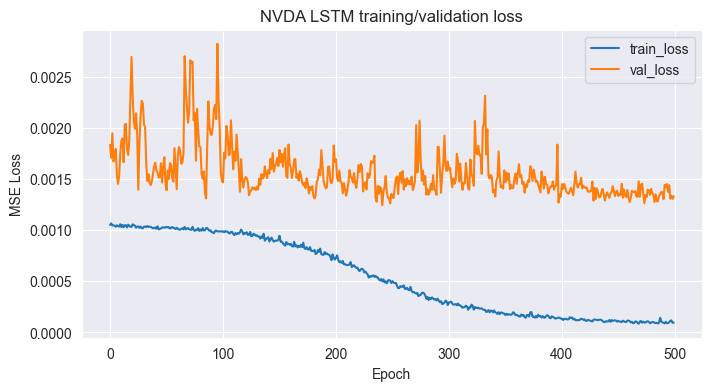

In [50]:
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=1800,
    restore_best_weights=True,
)

history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
)

# Plot training/validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"{TICKER} LSTM training/validation loss")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
param_grid = [
    {"lstm_units": 32, "dense_units": 16, "lr": 1e-3},
    {"lstm_units": 64, "dense_units": 32, "lr": 1e-3},
    {"lstm_units": 64, "dense_units": 64, "lr": 5e-4},
]

results = []

for i, params in enumerate(param_grid):
    print(f"\n=== Trial {i+1} / {len(param_grid)}: {params} ===")
    tmp_model = build_lstm_model(
        LOOKBACK,
        n_features,
        lstm_units=params["lstm_units"],
        dense_units=params["dense_units"],
        learning_rate=params["lr"],
    )

    tmp_history = tmp_model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=40,
        batch_size=32,
        callbacks=[
            callbacks.EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True,
            )
        ],
        verbose=0,
    )

    val_mse = min(tmp_history.history["val_loss"])
    print("Best val MSE:", val_mse)

    results.append(
        {
            "params": params,
            "val_mse": float(val_mse),
            "model": tmp_model,
        }
    )

# pick best model by val_mse
best = min(results, key=lambda r: r["val_mse"])
best_model = best["model"]
print("\nBest params:", best["params"], "with val_mse:", best["val_mse"])

# Optionally, replace our original model with the best one:
model = best_model


=== Trial 1 / 3: {'lstm_units': 32, 'dense_units': 16, 'lr': 0.001} ===


/Users/khai.tran/Stock-Predictor-v2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best val MSE: 0.0032758298330008984

=== Trial 2 / 3: {'lstm_units': 64, 'dense_units': 32, 'lr': 0.001} ===
Best val MSE: 0.0057584731839597225

=== Trial 3 / 3: {'lstm_units': 64, 'dense_units': 64, 'lr': 0.0005} ===
Best val MSE: 0.003888295730575919

Best params: {'lstm_units': 32, 'dense_units': 16, 'lr': 0.001} with val_mse: 0.0032758298330008984


Test MSE: 0.013736
Test MAE: 0.090781


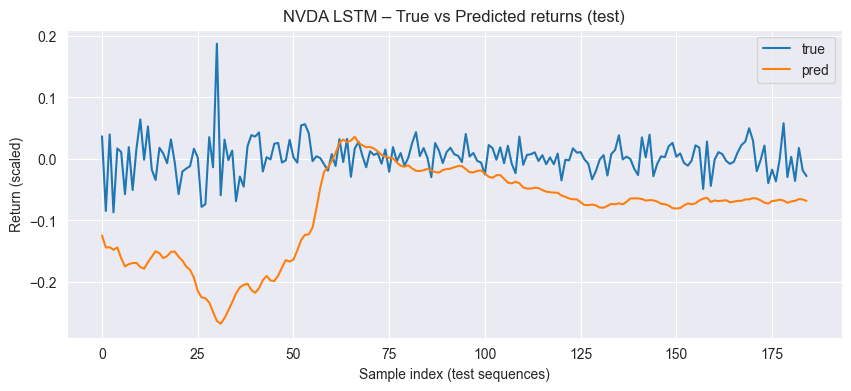

In [52]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test MSE: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

y_test_pred = model.predict(X_test_seq, verbose=0).flatten()

plt.figure(figsize=(10, 4))
plt.plot(y_test_seq, label="true")
plt.plot(y_test_pred, label="pred")
plt.xlabel("Sample index (test sequences)")
plt.ylabel("Return (scaled)")
plt.title(f"{TICKER} LSTM – True vs Predicted returns (test)")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Build one continuous feature matrix to take last LOOKBACK rows
X_all = pd.concat([X_train, X_val, X_test, X_pred], axis=0)

if len(X_all) < LOOKBACK:
    raise ValueError("Not enough rows to build final prediction window.")

latest_window = X_all.iloc[-LOOKBACK:].values.astype(np.float32)
latest_window = latest_window.reshape(1, LOOKBACK, n_features)

next_return_pred = float(model.predict(latest_window, verbose=0)[0, 0])
print(f"Predicted next-day return: {next_return_pred:.6f}")

# Provide the actual last close price here:
last_close_price = 181.36000061035156

next_price_pred = float(last_close_price * (1.0 + next_return_pred))
print(f"Last close price: {last_close_price}")
print(f"Predicted next close price: {next_price_pred:.4f}")

Predicted next-day return: -0.065696
Last close price: 181.36000061035156
Predicted next close price: 169.4454


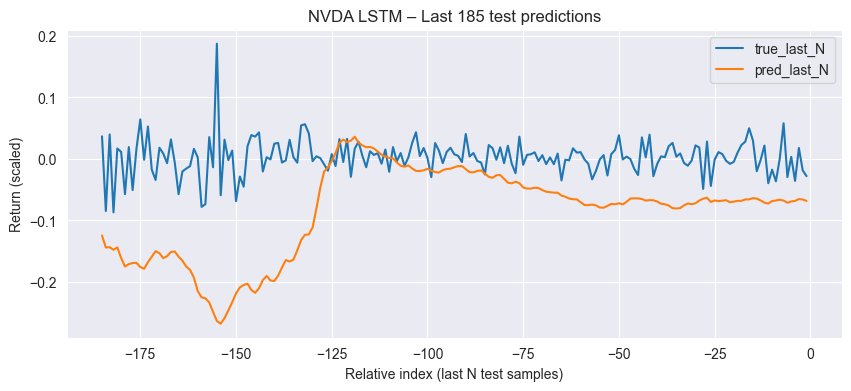

In [54]:
N = 200  # how many last test samples to visualize
N = min(N, len(y_test_seq))

plt.figure(figsize=(10, 4))
plt.plot(range(-N, 0), y_test_seq[-N:], label="true_last_N")
plt.plot(range(-N, 0), y_test_pred[-N:], label="pred_last_N")
plt.xlabel("Relative index (last N test samples)")
plt.ylabel("Return (scaled)")
plt.title(f"{TICKER} LSTM – Last {N} test predictions")
plt.legend()
plt.grid(True)
plt.show()